Initial columns: ['REF_AREA', 'Geographic area', 'INDICATOR', 'Indicator', 'SEX', 'Sex', 'AGE', 'Current age', 'WEALTH_QUINTILE', 'Wealth Quintile', 'RESIDENCE', 'Residence', 'MATERNAL_EDU_LVL', "Mother's Education Level", 'HEAD_OF_HOUSE', 'Head of House', 'REPORTING_LVL', 'Reporting level', 'INDICATOR_METADATA', 'UNIT_MULTIPLIER', 'Unit multiplier', 'UNIT_MEASURE', 'Unit of measure', 'SOURCE_LINK', 'SERIES_FOOTNOTE', 'CUSTODIAN', 'PUBLICATION_DATE', 'TIME_PERIOD', 'OBS_VALUE', 'SOWC_FLAG_A', 'SOWC flag A', 'DATA_SOURCE', 'OBS_STATUS', 'Observation Status', 'OBS_CONF', 'Observation confidentaility', 'LOWER_BOUND', 'UPPER_BOUND', 'STD_ERR', 'WGTD_SAMPL_SIZE', 'TIME_PERIOD_METHOD', 'Time period activity related to when the data are collected', 'COVERAGE_TIME', 'FREQ_COLL', 'Time interval at which the source data are collected', 'OBS_FOOTNOTE']
    REF_AREA Geographic area       INDICATOR  \
0  UNDEV_002          Africa  NT_ANT_HAZ_NE2   
1  UNDEV_002          Africa  NT_ANT_HAZ_NE2   
2 

<ipython-input-4-2ac435c662a7>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=to_drop, inplace=True)
<ipython-input-4-2ac435c662a7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['OBS_VALUE'] = pd.to_numeric(df['OBS_VALUE'], errors='coerce')
<ipython-input-4-2ac435c662a7>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

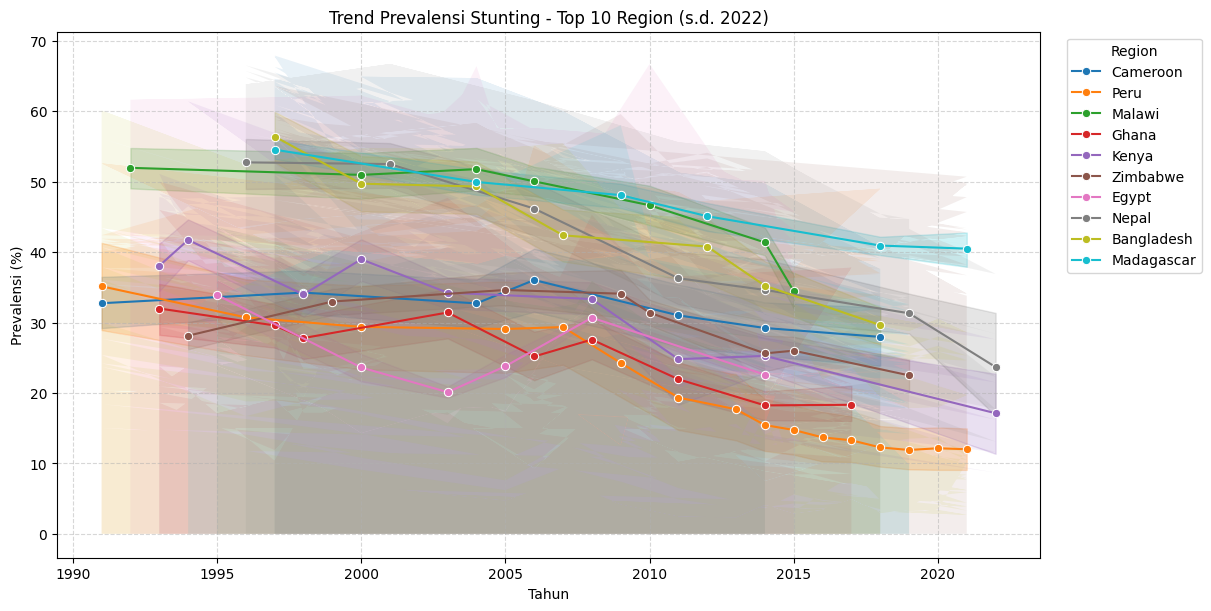

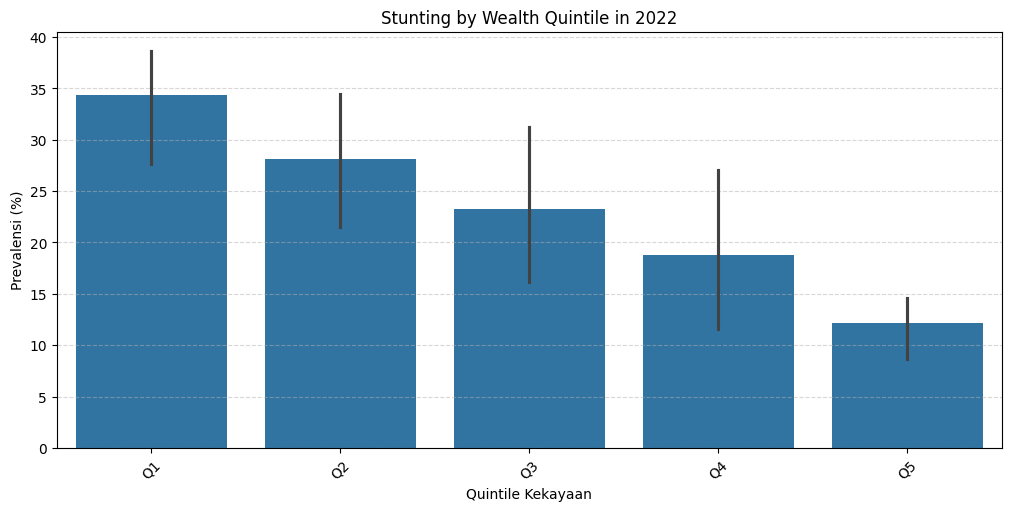

Residence categories: {'_T': 15}


<ipython-input-4-2ac435c662a7>:108: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title='Residence', bbox_to_anchor=(1.02,1))


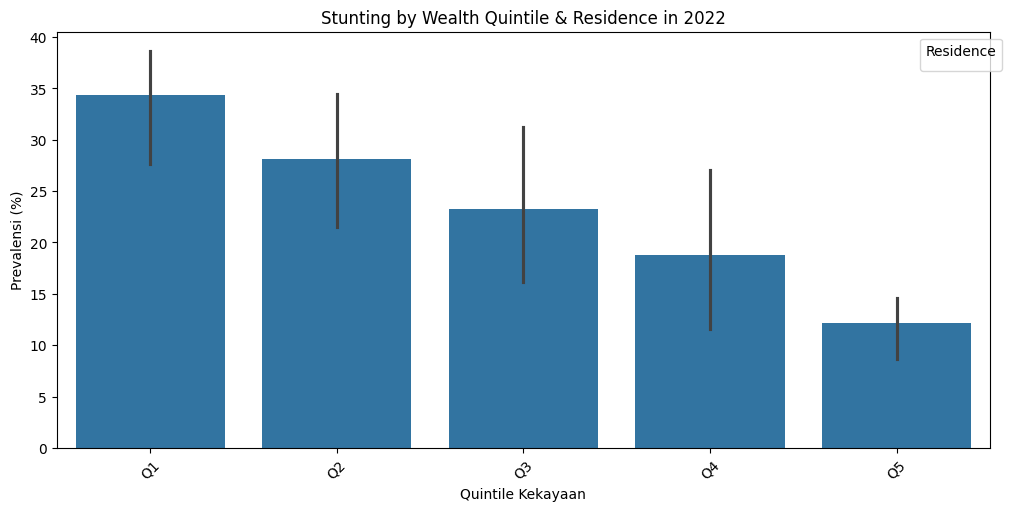

<ipython-input-4-2ac435c662a7>:116: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title='Sex', bbox_to_anchor=(1.02,1))


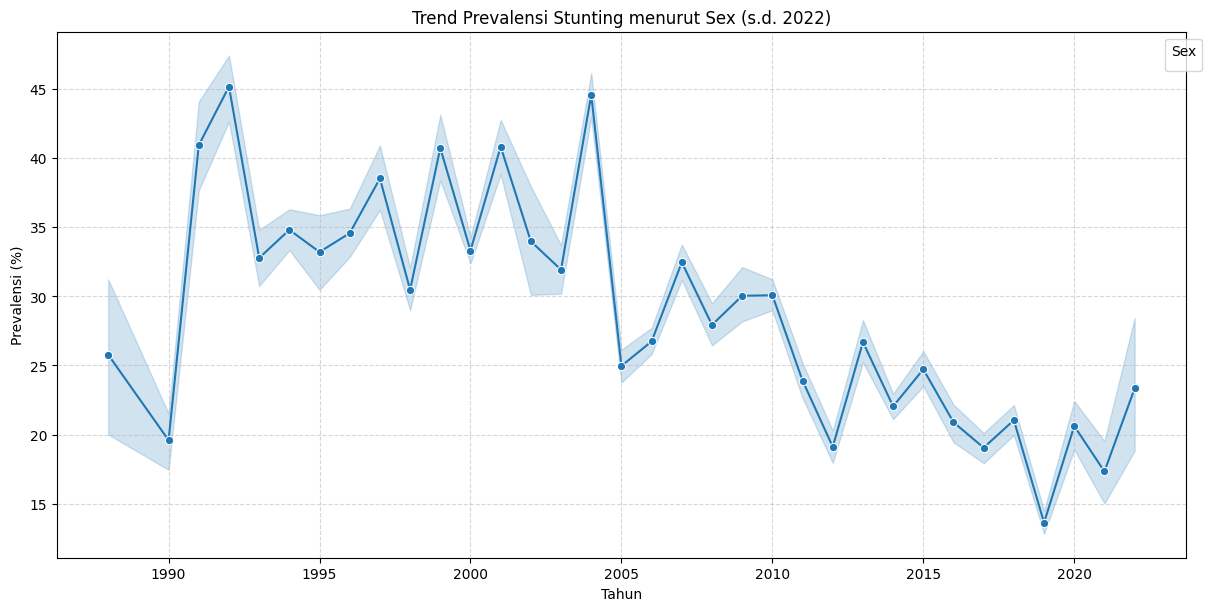

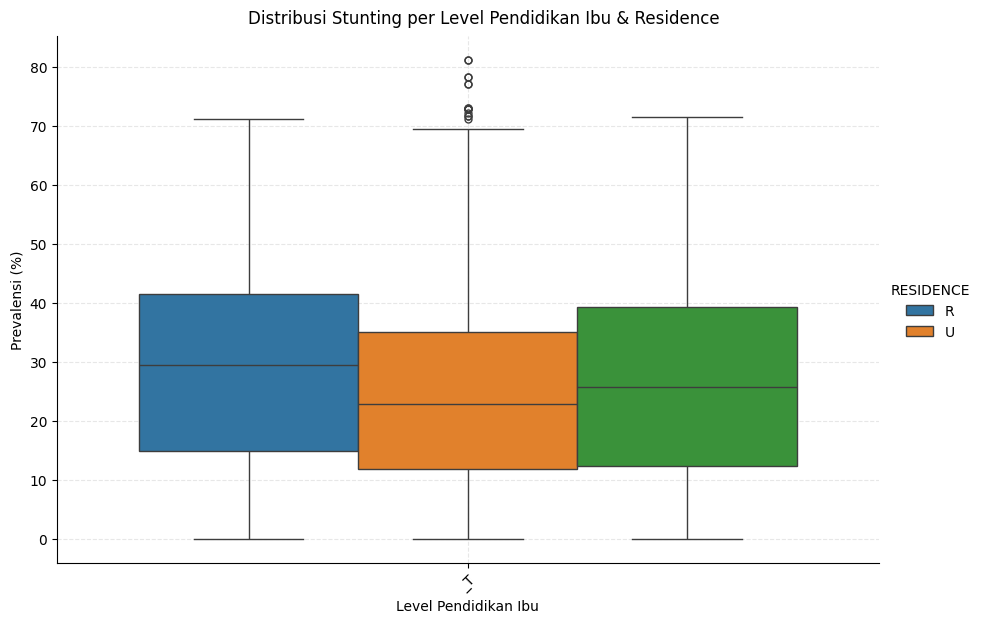

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ===== 1. LOAD & INSPECT DATA =====
DF_FILENAME = 'NUTRITION.csv'
df = pd.read_csv(DF_FILENAME)
print("Initial columns:", df.columns.tolist())
print(df.head())

# ===== 2. CLEANING & PREPARE =====
# 2.1 Standardize column names
df.columns = (
    df.columns
      .str.strip()
      .str.upper()
      .str.replace(' ', '_')
      .str.replace('[^A-Z0-9_]', '', regex=True)
)

# 2.1b Drop duplicate columns
df = df.loc[:, ~df.columns.duplicated()]
print("Columns after cleaning & dedup:", df.columns.tolist())

# 2.2 Drop columns with >80% missing
missing_frac = df.isna().mean()
to_drop = missing_frac[missing_frac > 0.8].index.tolist()
print("Dropping columns (>80% missing):", to_drop)
df.drop(columns=to_drop, inplace=True)

# 2.3 Convert OBS_VALUE to numeric and impute missing with median
df['OBS_VALUE'] = pd.to_numeric(df['OBS_VALUE'], errors='coerce')
median_obs = df['OBS_VALUE'].median()
df['OBS_VALUE'] = df['OBS_VALUE'].fillna(median_obs)
print(f"Imputed OBS_VALUE NaN with median: {median_obs}")

# 2.4 Convert WGTD_SAMPL_SIZE and impute median
if 'WGTD_SAMPL_SIZE' in df.columns:
    df['WGTD_SAMPL_SIZE'] = pd.to_numeric(df['WGTD_SAMPL_SIZE'], errors='coerce')
    median_wg = df['WGTD_SAMPL_SIZE'].median()
    df['WGTD_SAMPL_SIZE'] = df['WGTD_SAMPL_SIZE'].fillna(median_wg)
    print(f"Imputed WGTD_SAMPL_SIZE NaN with median: {median_wg}")

# 2.5 Create OBS_FOOTNOTE_FLAG
if 'OBS_FOOTNOTE' in df.columns:
    df['OBS_FOOTNOTE_FLAG'] = df['OBS_FOOTNOTE'].notna().astype(int)
    print("Created OBS_FOOTNOTE_FLAG column")

# 2.6 Parse TIME_PERIOD and keep valid
df['TIME_PERIOD'] = pd.to_datetime(df['TIME_PERIOD'], format='%Y', errors='coerce')
df = df.dropna(subset=['TIME_PERIOD'])

# 2.7 Create YEAR
df['YEAR'] = df['TIME_PERIOD'].dt.year

# 2.8 Remove invalid WEALTH_QUINTILE entries
invalid_quint = ['-T', '_T', ' ']
df = df[~df['WEALTH_QUINTILE'].isin(invalid_quint)]

# Confirm key columns
for col in ['WEALTH_QUINTILE', 'RESIDENCE', 'GEOGRAPHIC_AREA', 'SEX', 'MATERNAL_EDU_LVL']:
    if col not in df.columns:
        raise KeyError(f"Missing column: {col}")

# Subset latest year
latest_year = int(df['YEAR'].max())
df_latest = df[df['YEAR'] == latest_year]

# Determine wealth quintile order
order_quint = sorted(df_latest['WEALTH_QUINTILE'].unique())
print(f"Wealth quintiles for {latest_year}: {order_quint}")

# ===== 3. CASE A: Trends by Top 10 Regions =====
top_regions = (
    df['GEOGRAPHIC_AREA']
    .value_counts()
    .head(10)
    .index
    .tolist()
)
df_top = df[df['GEOGRAPHIC_AREA'].isin(top_regions)]

fig, ax = plt.subplots(figsize=(12,6), constrained_layout=True)
sns.lineplot(data=df_top, x='YEAR', y='OBS_VALUE', hue='GEOGRAPHIC_AREA', marker='o', ax=ax)
for region, grp in df_top.groupby('GEOGRAPHIC_AREA'):
    ax.fill_between(grp['YEAR'], grp['OBS_VALUE'], alpha=0.1)
ax.set(title=f"Trend Prevalensi Stunting - Top 10 Region (s.d. {latest_year})", xlabel='Tahun', ylabel='Prevalensi (%)')
ax.legend(title='Region', bbox_to_anchor=(1.02,1))
ax.grid(True, linestyle='--', alpha=0.5)
plt.show()

# ===== 4. CASE B: Wealth Quintile =====
# 4.1 Simple bar
df_latest_filtered = df_latest.copy()

fig, ax = plt.subplots(figsize=(10,5), constrained_layout=True)
sns.barplot(data=df_latest_filtered, x='WEALTH_QUINTILE', y='OBS_VALUE', order=order_quint, ax=ax)
ax.set(title=f"Stunting by Wealth Quintile in {latest_year}", xlabel='Quintile Kekayaan', ylabel='Prevalensi (%)')
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.show()

# 4.2 Grouped bar: Wealth × Residence
print("Residence categories:", df_latest_filtered['RESIDENCE'].value_counts().to_dict())
fig, ax = plt.subplots(figsize=(10,5), constrained_layout=True)
sns.barplot(data=df_latest_filtered, x='WEALTH_QUINTILE', y='OBS_VALUE', hue='RESIDENCE', order=order_quint, ax=ax)
ax.set(title=f"Stunting by Wealth Quintile & Residence in {latest_year}", xlabel='Quintile Kekayaan', ylabel='Prevalensi (%)')
ax.legend(title='Residence', bbox_to_anchor=(1.02,1))
plt.xticks(rotation=45)
plt.show()

# ===== 5. CASE C: Trends by Sex =====
fig, ax = plt.subplots(figsize=(12,6), constrained_layout=True)
sns.lineplot(data=df, x='YEAR', y='OBS_VALUE', hue='SEX', marker='o', ax=ax)
ax.set(title=f"Trend Prevalensi Stunting menurut Sex (s.d. {latest_year})", xlabel='Tahun', ylabel='Prevalensi (%)')
ax.legend(title='Sex', bbox_to_anchor=(1.02,1))
ax.grid(True, linestyle='--', alpha=0.5)
plt.show()

# ===== 6. CASE D: Distribution by Maternal Education & Residence =====
fig = sns.catplot(data=df, x='MATERNAL_EDU_LVL', y='OBS_VALUE', hue='RESIDENCE', kind='box', height=6, aspect=1.5)
fig.fig.suptitle('Distribusi Stunting per Level Pendidikan Ibu & Residence', y=1.02)
fig.set_axis_labels('Level Pendidikan Ibu', 'Prevalensi (%)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()


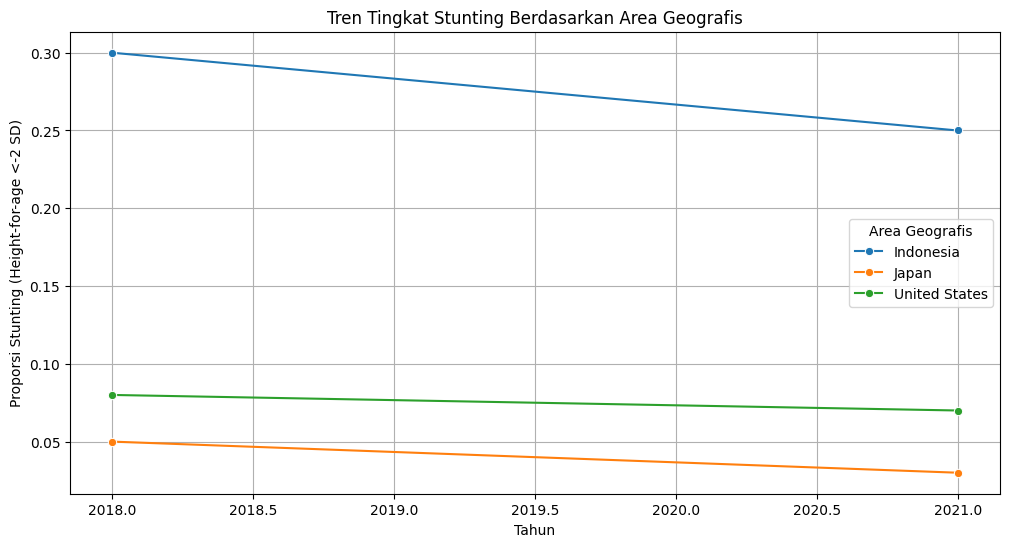

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Contoh data (ganti dengan data Anda)
data = {'REF_AREA': ['IDN', 'IDN', 'JPN', 'JPN', 'USA', 'USA'],
        'Geographic area': ['Indonesia', 'Indonesia', 'Japan', 'Japan', 'United States', 'United States'],
        'TIME_PERIOD': [2018, 2021, 2018, 2021, 2018, 2021],
        'OBS_VALUE': [0.30, 0.25, 0.05, 0.03, 0.08, 0.07]}
df = pd.DataFrame(data)

# Visualisasi menggunakan line plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='TIME_PERIOD', y='OBS_VALUE', hue='Geographic area', marker='o')
plt.title('Tren Tingkat Stunting Berdasarkan Area Geografis')
plt.xlabel('Tahun')
plt.ylabel('Proporsi Stunting (Height-for-age <-2 SD)')
plt.grid(True)
plt.legend(title='Area Geografis')
plt.show()

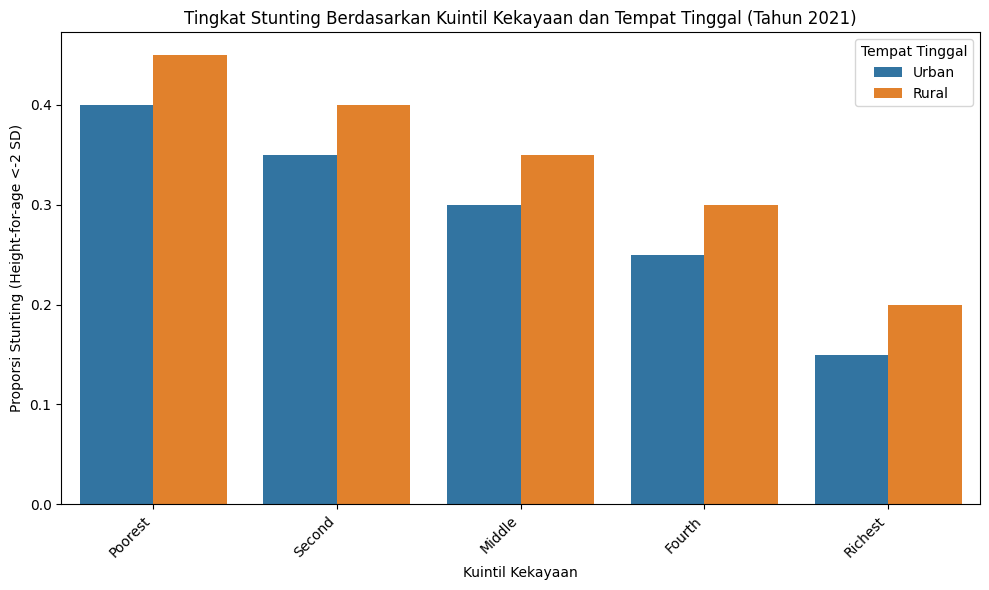

In [ ]:
# Contoh data (ganti dengan data Anda - tambahkan kolom WEALTH_QUINTILE dan RESIDENCE)
data_wealth_residence = {'Geographic area': ['Indonesia'] * 10,
                         'TIME_PERIOD': [2021] * 10,
                         'WEALTH_QUINTILE': ['Poorest', 'Poorest', 'Second', 'Second', 'Middle', 'Middle', 'Fourth', 'Fourth', 'Richest', 'Richest'],
                         'RESIDENCE': ['Urban', 'Rural', 'Urban', 'Rural', 'Urban', 'Rural', 'Urban', 'Rural', 'Urban', 'Rural'],
                         'OBS_VALUE': [0.40, 0.45, 0.35, 0.40, 0.30, 0.35, 0.25, 0.30, 0.15, 0.20]}
df_wealth_residence = pd.DataFrame(data_wealth_residence)

# Visualisasi menggunakan bar plot kelompok
plt.figure(figsize=(10, 6))
sns.barplot(data=df_wealth_residence, x='WEALTH_QUINTILE', y='OBS_VALUE', hue='RESIDENCE')
plt.title('Tingkat Stunting Berdasarkan Kuintil Kekayaan dan Tempat Tinggal (Tahun 2021)')
plt.xlabel('Kuintil Kekayaan')
plt.ylabel('Proporsi Stunting (Height-for-age <-2 SD)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Tempat Tinggal')
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ===== 1. LOAD & INSPECT DATA =====
DF_FILENAME = 'NUTRITION.csv'
df = pd.read_csv(DF_FILENAME)
print("Initial columns:", df.columns.tolist())
print(df.head())

# ===== 2. CLEANING & PREPARE =====
# 2.1 Standardize column names
df.columns = (
    df.columns
    .str.strip()
    .str.upper()
    .str.replace(' ', '_')
    .str.replace('[^A-Z0-9_]', '', regex=True)
)

# 2.1b Drop duplicate columns
df = df.loc[:, ~df.columns.duplicated()]
print("Columns after cleaning & dedup:", df.columns.tolist())

# ===== 2.1c Filter for Stunting Indicator =====
stunting_indicator_name = 'STUNTING'  # Contoh, perlu disesuaikan
df = df[df['INDICATOR'].str.upper().str.contains(stunting_indicator_name, na=False)]
print(f"DataFrame filtered for indicator: {stunting_indicator_name}")

# --- PERIKSA DATAFRAME SETELAH FILTERING ---
print("\nInformasi DataFrame setelah filtering indikator:")
print(df.info())
print("\nBeberapa baris pertama DataFrame setelah filtering indikator:")
print(df.head())
print("\nNilai unik di kolom INDICATOR setelah filtering:")
print(df['INDICATOR'].unique())
print("\nNilai unik di kolom YEAR setelah filtering:")
print(df['YEAR'].unique())
# --- AKHIR PEMERIKSAAN ---

# 2.2 Drop columns with >80% missing
missing_frac = df.isna().mean()
to_drop = missing_frac[missing_frac > 0.8].index.tolist()
print("Dropping columns (>80% missing):", to_drop)
df.drop(columns=to_drop, inplace=True)

# 2.3 Convert OBS_VALUE to numeric and impute missing with median
df['OBS_VALUE'] = pd.to_numeric(df['OBS_VALUE'], errors='coerce')
median_obs = df['OBS_VALUE'].median()
df['OBS_VALUE'] = df['OBS_VALUE'].fillna(median_obs)
print(f"Imputed OBS_VALUE NaN with median: {median_obs}")

# 2.4 Convert WGTD_SAMPL_SIZE and impute median
if 'WGTD_SAMPL_SIZE' in df.columns:
    df['WGTD_SAMPL_SIZE'] = pd.to_numeric(df['WGTD_SAMPL_SIZE'], errors='coerce')
    median_wg = df['WGTD_SAMPL_SIZE'].median()
    df['WGTD_SAMPL_SIZE'] = df['WGTD_SAMPL_SIZE'].fillna(median_wg)
    print(f"Imputed WGTD_SAMPL_SIZE NaN with median: {median_wg}")

# 2.5 Create OBS_FOOTNOTE_FLAG
if 'OBS_FOOTNOTE' in df.columns:
    df['OBS_FOOTNOTE_FLAG'] = df['OBS_FOOTNOTE'].notna().astype(int)
    print("Created OBS_FOOTNOTE_FLAG column")

# 2.6 Parse TIME_PERIOD and keep valid
df['TIME_PERIOD'] = pd.to_datetime(df['TIME_PERIOD'], format='%Y', errors='coerce')
df = df.dropna(subset=['TIME_PERIOD'])

# 2.7 Create YEAR
df['YEAR'] = df['TIME_PERIOD'].dt.year

# --- PERIKSA KEBERADAAN KOLOM 'YEAR' SEBELUM SUBSETTING ---
print("\nKolom dalam DataFrame sebelum subsetting tahun:")
print(df.columns.tolist())

if 'YEAR' not in df.columns:
    print("Error: Kolom 'YEAR' tidak ditemukan dalam DataFrame.")
else:
    # Subset latest year
    latest_year = int(df['YEAR'].max())
    df_latest = df[df['YEAR'] == latest_year]
    print(f"Tahun terakhir dalam data: {latest_year}")

    # ===== 3. CASE A: Trends by Top 10 Regions =====
    top_regions = (
        df['GEOGRAPHIC_AREA']
        .value_counts()
        .head(10)
        .index
        .tolist()
    )
    df_top = df[df['GEOGRAPHIC_AREA'].isin(top_regions)]

    fig, ax = plt.subplots(figsize=(12,6), constrained_layout=True)
    sns.lineplot(data=df_top, x='YEAR', y='OBS_VALUE', hue='GEOGRAPHIC_AREA', marker='o', ax=ax)
    for region, grp in df_top.groupby('GEOGRAPHIC_AREA'):
        ax.fill_between(grp['YEAR'], grp['OBS_VALUE'], alpha=0.1)
    ax.set(title=f"Trend Prevalensi Stunting - Top 10 Region (s.d. {latest_year})", xlabel='Tahun', ylabel='Prevalensi (%)')
    ax.legend(title='Region', bbox_to_anchor=(1.02,1))
    ax.grid(True, linestyle='--', alpha=0.5)
    plt.show()

    # ===== 4. CASE B: Wealth Quintile =====
    # 4.1 Simple bar
    df_latest_filtered = df_latest.copy()

    fig, ax = plt.subplots(figsize=(10,5), constrained_layout=True)
    sns.barplot(data=df_latest_filtered, x='WEALTH_QUINTILE', y='OBS_VALUE', order=order_quint, ax=ax)
    ax.set(title=f"Stunting by Wealth Quintile in {latest_year}", xlabel='Quintile Kekayaan', ylabel='Prevalensi (%)')
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    plt.xticks(rotation=45)
    plt.show()

    # 4.2 Grouped bar: Wealth × Residence
    print("Residence categories:", df_latest_filtered['RESIDENCE'].value_counts().to_dict())
    fig, ax = plt.subplots(figsize=(10,5), constrained_layout=True)
    sns.barplot(data=df_latest_filtered, x='WEALTH_QUINTILE', y='OBS_VALUE', hue='RESIDENCE', order=order_quint, ax=ax)
    ax.set(title=f"Stunting by Wealth Quintile & Residence in {latest_year}", xlabel='Quintile Kekayaan', ylabel='Prevalensi (%)')
    ax.legend(title='Residence', bbox_to_anchor=(1.02,1))
    plt.xticks(rotation=45)
    plt.show()

    # ===== 5. CASE C: Trends by Sex =====
    fig, ax = plt.subplots(figsize=(12,6), constrained_layout=True)
    sns.lineplot(data=df, x='YEAR', y='OBS_VALUE', hue='SEX', marker='o', ax=ax)
    ax.set(title=f"Trend Prevalensi Stunting menurut Sex (s.d. {latest_year})", xlabel='Tahun', ylabel='Prevalensi (%)')
    ax.legend(title='Sex', bbox_to_anchor=(1.02,1))
    ax.grid(True, linestyle='--', alpha=0.5)
    plt.show()

    # ===== 6. CASE D: Distribution by Maternal Education & Residence =====
    fig = sns.catplot(data=df, x='MATERNAL_EDU_LVL', y='OBS_VALUE', hue='RESIDENCE', kind='box', height=6, aspect=1.5)
    fig.fig.suptitle('Distribusi Stunting per Level Pendidikan Ibu & Residence', y=1.02)
    fig.set_axis_labels('Level Pendidikan Ibu', 'Prevalensi (%)')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.show()

    # ===== 7. CASE E (Tambahan): Stunting by Wealth Quintile and Sex in Latest Year =====
    fig, ax = plt.subplots(figsize=(10, 6), constrained_layout=True)
    sns.barplot(data=df_latest, x='WEALTH_QUINTILE', y='OBS_VALUE', hue='SEX', order=order_quint, ax=ax)
    ax.set(title=f"Stunting by Wealth Quintile & Sex in {latest_year}", xlabel='Quintile Kekayaan', ylabel='Prevalensi (%)')
    ax.legend(title='Sex', bbox_to_anchor=(1.02, 1))
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()

    # ===== 8. CASE F (Tambahan): Trend Stunting by Maternal Education Level =====
    # Group data by year and maternal education level, then calculate the mean prevalence
    df_edu_trend = df.groupby(['YEAR', 'MATERNAL_EDU_LVL'])['OBS_VALUE'].mean().reset_index()

    plt.figure(figsize=(14, 7), constrained_layout=True)
    sns.lineplot(data=df_edu_trend, x='YEAR', y='OBS_VALUE', hue='MATERNAL_EDU_LVL', marker='o')
    plt.title(f'Tren Prevalensi Stunting per Tingkat Pendidikan Ibu (s.d. {latest_year})')
    plt.xlabel('Tahun')
    plt.ylabel('Rata-rata Prevalensi (%)')
    plt.legend(title='Pendidikan Ibu', bbox_to_anchor=(1.02, 1))
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xticks(df_edu_trend['YEAR'].unique())
    plt.show()
else:
    print("Tidak ada data stunting yang ditemukan. Mohon periksa kembali nama indikator yang digunakan untuk filtering.")

SyntaxError: invalid syntax (<ipython-input-15-4e32724ab39a>, line 161)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ===== 1. LOAD & INSPECT DATA =====
DF_FILENAME = 'NUTRITION.csv'
df = pd.read_csv(DF_FILENAME)
print("Initial columns:", df.columns.tolist())
print(df.head())

# ===== 2. CLEANING & PREPARE =====
# 2.1 Standardize column names
df.columns = (
    df.columns
    .str.strip()
    .str.upper()
    .str.replace(' ', '_')
    .str.replace('[^A-Z0-9_]', '', regex=True)
)

# 2.1b Drop duplicate columns
df = df.loc[:, ~df.columns.duplicated()]
print("Columns after cleaning & dedup:", df.columns.tolist())

# ===== 2.1c Filter for Stunting Indicator =====
stunting_indicator_name = 'STUNTING'  # Contoh, perlu disesuaikan
df = df[df['INDICATOR'].str.upper().str.contains(stunting_indicator_name, na=False)]
print(f"DataFrame filtered for indicator: {stunting_indicator_name}")

# --- PERIKSA DATAFRAME SETELAH FILTERING ---
print("\nInformasi DataFrame setelah filtering indikator:")
print(df.info())
print("\nBeberapa baris pertama DataFrame setelah filtering indikator:")
print(df.head())
print("\nNilai unik di kolom INDICATOR setelah filtering:")
print(df['INDICATOR'].unique())
print("\nNilai unik di kolom YEAR setelah filtering:")
print(df['YEAR'].unique())
# --- AKHIR PEMERIKSAAN ---

# 2.2 Drop columns with >80% missing
missing_frac = df.isna().mean()
to_drop = missing_frac[missing_frac > 0.8].index.tolist()
print("Dropping columns (>80% missing):", to_drop)
df.drop(columns=to_drop, inplace=True)

# 2.3 Convert OBS_VALUE to numeric and impute missing with median
df['OBS_VALUE'] = pd.to_numeric(df['OBS_VALUE'], errors='coerce')
median_obs = df['OBS_VALUE'].median()
df['OBS_VALUE'] = df['OBS_VALUE'].fillna(median_obs)
print(f"Imputed OBS_VALUE NaN with median: {median_obs}")

# 2.4 Convert WGTD_SAMPL_SIZE and impute median
if 'WGTD_SAMPL_SIZE' in df.columns:
    df['WGTD_SAMPL_SIZE'] = pd.to_numeric(df['WGTD_SAMPL_SIZE'], errors='coerce')
    median_wg = df['WGTD_SAMPL_SIZE'].median()
    df['WGTD_SAMPL_SIZE'] = df['WGTD_SAMPL_SIZE'].fillna(median_wg)
    print(f"Imputed WGTD_SAMPL_SIZE NaN with median: {median_wg}")

# 2.5 Create OBS_FOOTNOTE_FLAG
if 'OBS_FOOTNOTE' in df.columns:
    df['OBS_FOOTNOTE_FLAG'] = df['OBS_FOOTNOTE'].notna().astype(int)
    print("Created OBS_FOOTNOTE_FLAG column")

# 2.6 Parse TIME_PERIOD and keep valid
df['TIME_PERIOD'] = pd.to_datetime(df['TIME_PERIOD'], format='%Y', errors='coerce')
df = df.dropna(subset=['TIME_PERIOD'])

# 2.7 Create YEAR
df['YEAR'] = df['TIME_PERIOD'].dt.year

# --- PERIKSA KEBERADAAN KOLOM 'YEAR' SEBELUM SUBSETTING ---
print("\nKolom dalam DataFrame sebelum subsetting tahun:")
print(df.columns.tolist())

if 'YEAR' not in df.columns:
    print("KOLOM YEAR TIDAK ADA")
else:
    print("KOLOM YEAR ADA")

Initial columns: ['REF_AREA', 'Geographic area', 'INDICATOR', 'Indicator', 'SEX', 'Sex', 'AGE', 'Current age', 'WEALTH_QUINTILE', 'Wealth Quintile', 'RESIDENCE', 'Residence', 'MATERNAL_EDU_LVL', "Mother's Education Level", 'HEAD_OF_HOUSE', 'Head of House', 'REPORTING_LVL', 'Reporting level', 'INDICATOR_METADATA', 'UNIT_MULTIPLIER', 'Unit multiplier', 'UNIT_MEASURE', 'Unit of measure', 'SOURCE_LINK', 'SERIES_FOOTNOTE', 'CUSTODIAN', 'PUBLICATION_DATE', 'TIME_PERIOD', 'OBS_VALUE', 'SOWC_FLAG_A', 'SOWC flag A', 'DATA_SOURCE', 'OBS_STATUS', 'Observation Status', 'OBS_CONF', 'Observation confidentaility', 'LOWER_BOUND', 'UPPER_BOUND', 'STD_ERR', 'WGTD_SAMPL_SIZE', 'TIME_PERIOD_METHOD', 'Time period activity related to when the data are collected', 'COVERAGE_TIME', 'FREQ_COLL', 'Time interval at which the source data are collected', 'OBS_FOOTNOTE']
    REF_AREA Geographic area       INDICATOR  \
0  UNDEV_002          Africa  NT_ANT_HAZ_NE2   
1  UNDEV_002          Africa  NT_ANT_HAZ_NE2   
2 

KeyError: 'YEAR'